<!-- (note to self) wanted weight matrix shape:

`(n_post, n_pre)` -->

In [1]:
import sys
import scipy
sys.path.append('/home/david/source/diplomka')

from execute_model import init_parser, init_model_path
from nn_model.model_executer import ModelExecuter
import nn_model.globals
from nn_model.globals import POS_ORI_DICT, LAYER_TO_PARENT, EXCITATORY_LAYERS, MODEL_SIZES, NEURON_SELECTION, PROJECT_ROOT
from nn_model.connection_learning import ConnectionAffine, get_features, pairwise_delta
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import matplotlib.colors as colors
from dataclasses import dataclass, field
import seaborn as sns
import pickle
import matplotlib.colors as mcolors
import re

from nn_model.type_variants import LayerType, PathDefaultFields

sns.set_theme(
    style="ticks",
    context="paper",
)

In [ ]:
@dataclass
class NeuralConnectionPopulation:
    pre: str
    post: str
    weight: np.ndarray

    def get_autapse(self):
        if self.pre != self.post:
            return None
        return self.weight.diagonal()
    
    def get_title(self):
        def layer_to_polarity(layer):
            if layer in EXCITATORY_LAYERS:
                return 'Exc'
            return 'Inh'
        title = LAYER_TO_PARENT[self.pre]
        p1 = layer_to_polarity(self.pre)
        p2 = layer_to_polarity(self.post)
        return f"{title} {p1}->{p2}"

    def get_features(self):
        return get_features(self.pre, self.post)
    
def extract_real_connections(fname='exported_connections.pickle'):
    with open(fname, 'rb') as f:
        d = pickle.load(f)

    d = {k.removeprefix('V1').removesuffix('Connection'): v for k, v in d.items() if 'Aff' not in k}

    translate = {
        "L4Exc": 'V1_Exc_L4',
        "L4Inh": 'V1_Inh_L4',
        "L23Exc": 'V1_Exc_L2/3',
        "L23Inh": 'V1_Inh_L2/3',
    }
    pattern = re.compile(r'^(L\d+(?:Exc|Inh))(L\d+(?:Exc|Inh))$')

    res = {}

    for k, v in d.items():
        # population names
        m = pattern.match(k)
        pre, post = m.groups()
        pre = translate[pre]
        post = translate[post]
        if LAYER_TO_PARENT[pre] != LAYER_TO_PARENT[post]:
            continue
        # sizes
        pre_size = MODEL_SIZES[pre]
        post_size = MODEL_SIZES[post]
        # neuron subsets
        pre_filter = NEURON_SELECTION[pre].astype(int)
        post_filter = NEURON_SELECTION[post].astype(int)
        pre_translate = {v: i for i, v in enumerate(pre_filter)}
        post_translate = {v: i for i, v in enumerate(post_filter)}
        # dataframe of connections
        df = pd.DataFrame(v, columns=['pre', 'post', 'w'])
        df.pre = df.pre.astype(int)
        df.post = df.post.astype(int)
        # select the neuron subset
        df = df[df.pre.isin(pre_filter) & df.post.isin(post_filter)]
        # ensure that the indices arent out of range
        # [59, 47, 99, 99] -> [1, 0, 2, 2]
        # df['pre'] = df.pre.rank(method='dense').astype(int) - 1
        # df['post'] = df.post.rank(method='dense').astype(int) - 1
        df['pre'] = df['pre'].replace(pre_translate)
        df['post'] = df['post'].replace(post_translate)
        # choose subset
        df = df[df.post.isin(post_filter)]
        mat = np.zeros((post_size, pre_size))
        # create dense ndarray
        mat[df.post, df.pre] = df.w
        if pre not in EXCITATORY_LAYERS:
            mat *= -1
            assert np.min(mat.flatten()) <= 0
        else:
            assert np.max(mat.flatten()) >= 0
        yield NeuralConnectionPopulation(pre, post, mat)
        
@torch.no_grad()
def affine_module_to_population(x: ConnectionAffine) -> NeuralConnectionPopulation:
    lateral = x.weight()
    lateral = lateral.cpu().detach().numpy()
    return NeuralConnectionPopulation(
        x.layer_name_pre,
        x.layer_name_post,
        lateral,
    )

def get_executer(args_str):
    parser = init_parser()
    
    args = parser.parse_args(args_str.replace('"', '').split())
    args.model_filename = init_model_path(args)
    executer = ModelExecuter(args)
    executer._load_best_model()
    return executer
    
def get_affine_modules(executer):
    for idx, (layer_name, layer) in enumerate(executer.model.layers.items()):
        yield layer.rnn_cell.weights_hh
        yield layer.rnn_cell.weights_lateral

def extract_model_connections(args_str):
    executer = get_executer(args_str)
    for module in get_affine_modules(executer):
        pop = affine_module_to_population(module)
        yield pop

def set_start_end_idx(df):
    if df.empty:
        return df
    df['start_idx'] = df['size'].cumsum() - df['size']
    df['end_idx']   = df['start_idx'] + df['size'] - 1
    return df

def get_linear_modules(executer):
    for idx, (layer_name, layer) in enumerate(executer.model.layers.items()):
        hidden = layer.rnn_cell.weights_hh.weight
        exc = layer.rnn_cell.weights_ih_exc.weight
        inh = layer.rnn_cell.weights_ih_inh.weight
        post = layer.rnn_cell.layer_name
        post_parent = LAYER_TO_PARENT[post]

        yield NeuralConnectionPopulation(post, post, hidden.cpu().detach().numpy())
        in_constraints = layer.rnn_cell.input_constraints
                    
        in_exc = [x for x in in_constraints if x['type'] == 'exc']
        in_inh = [x for x in in_constraints if x['type'] == 'inh']
        in_exc = set_start_end_idx(pd.DataFrame(in_exc))
        in_inh = set_start_end_idx(pd.DataFrame(in_inh))
        assert len(in_exc) + len(in_inh) == len(in_constraints)

        # only select same-parent layers
        if not in_exc.empty:
            in_exc = in_exc[in_exc.name.apply(lambda x: LAYER_TO_PARENT[x] == post_parent)]
        if not in_inh.empty:
            in_inh = in_inh[in_inh.name.apply(lambda x: LAYER_TO_PARENT[x] == post_parent)]
        assert len(in_exc) + len(in_inh) == 1

        if not in_exc.empty:
            lateral_weight = exc
            layer = in_exc.iloc[0]
        else:
            lateral_weight = inh
            layer = in_inh.iloc[0]
            
        pre = layer['name']
        start_idx = layer['start_idx']
        end_idx = layer['end_idx']
        lateral_weight = lateral_weight[:, start_idx: end_idx+1]
        yield NeuralConnectionPopulation(pre, post, lateral_weight.cpu().detach().numpy())
        
def extract_linear_connections(args_str):
    exec = get_executer(args_str)
    yield from get_linear_modules(exec)

        
def extract_bins(feature_dict, fname='connection_files/exported_connections.pickle'):
    with open(fname, 'rb') as f:
        d = pickle.load(f)

    d = {k.removeprefix('V1').removesuffix('Connection'): v for k, v in d.items() if 'Aff' not in k}

    translate = {
        "L4Exc": 'V1_Exc_L4',
        "L4Inh": 'V1_Inh_L4',
        "L23Exc": 'V1_Exc_L23',
        "L23Inh": 'V1_Inh_L23',
    }
    pattern = re.compile(r'^(L\d+(?:Exc|Inh))(L\d+(?:Exc|Inh))$')
    
    # with open(f"{PROJECT_ROOT}/testing_dataset/pos_ori_phase_dictionary.pickle", "rb") as f:
    #     original_pos_ori = pickle.load(f)

    for k, v in d.items():
        # population names
        m = pattern.match(k)
        pre, post = m.groups()
        pre = translate[pre]
        post = translate[post]
        if LAYER_TO_PARENT[pre] != LAYER_TO_PARENT[post]:
            continue
        # dataframe of connections
        df = pd.DataFrame(v, columns=['pre', 'post', 'w'])
        df.pre = df.pre.astype(int)
        df.post = df.post.astype(int)
        if pre not in EXCITATORY_LAYERS:
            df['w'] *= -1
               
        f_pre = feature_dict[pre]
        f_post = feature_dict[post]
        for feat_key in f_pre.keys() & f_post.keys():
            pre_f = np.array(f_pre[feat_key])[df.pre.to_numpy()]
            post_f = np.array(f_post[feat_key])[df.post.to_numpy()]
            df[f'd{feat_key}'] = pre_f - post_f

        df['dist'] = (df['dx'] ** 2 + df['dy'] ** 2) ** 0.5
                
        yield NeuralConnectionPopulation(pre, post, df)


In [3]:
full_args_str = '--num_data_workers=8 --learning_rate=0.00003 --model=rnn_separate --num_epochs=40 --num_backpropagation_time_steps=10 --neuron_num_layers=3 --neuron_layer_size=10 --neuron_rnn_variant=gru --synaptic_adaptation_size=10 --synaptic_adaptation_num_layers=1 --neuron_residual --subset_variant=2'

with open('../testing_dataset/pos_ori_phase_dictionary.pickle', 'rb') as f:
    feature_dict = pickle.load(f)
    
all_populations_snn = list(extract_bins(feature_dict))
all_populations_rnn = list(extract_linear_connections(full_args_str))


l4_snn = sorted(
    [x for x in all_populations_snn if "L4" in x.pre.upper()],
    key=lambda x: (x.pre, x.post)
)
l23_snn = sorted(
    [x for x in all_populations_snn if "L2" in x.pre.upper()],
    key=lambda x: (x.pre, x.post)
)

l4_rnn = sorted(
    [x for x in all_populations_rnn if "L4" in x.pre.upper()],
    key=lambda x: (x.pre, x.post)
)
l23_rnn = sorted(
    [x for x in all_populations_rnn if "L2" in x.pre.upper()],
    key=lambda x: (x.pre, x.post)
)

# # Select only the subset of neurons from NEURON_SELECTION (For SNN model).
# for population in l4_snn + l23_snn:
#     pre_neuron_ids, post_neuron_ids = NEURON_SELECTION[population.pre], NEURON_SELECTION[population.post]  
#     weights = population.weight
    
#     new_weights = weights[
#         weights['pre'].isin(pre_neuron_ids) & 
#         weights['post'].isin(post_neuron_ids)
#     ]
#     population.weight = new_weights



/home/david/.cache/pypoetry/virtualenvs/neural-simulator-lOyI4ksM-py3.12/lib64/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/david/.cache/pypoetry/virtualenvs/neural-simulator-lOyI4ksM-py3.12/lib64/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def orientation_plot(data, title: str =  "",save_fig: str = ""):
    
    # Create scatter plot
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(data["x"], data["y"], c=data["ori"], cmap='viridis', s=80)

    # Add colorbar to show orientation mapping
    plt.colorbar(sc, label='Orientation (ori)')

    # Label axes
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title(title)

    if save_fig:
        plt.savefig(save_fig, bbox_inches='tight')
    plt.show()

V1_Exc_L23


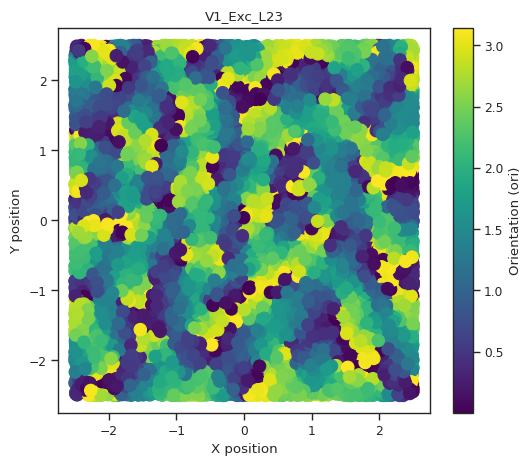

V1_Inh_L23


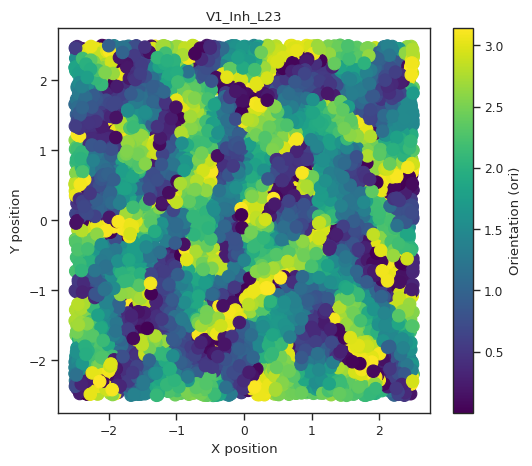

V1_Exc_L4


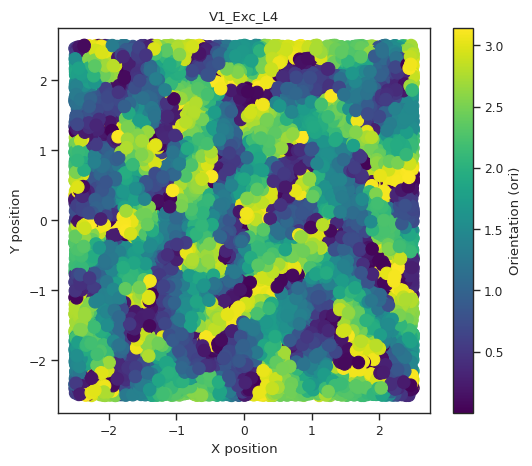

V1_Inh_L4


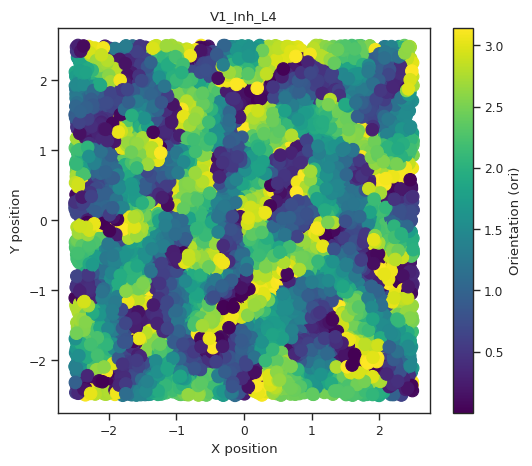

In [22]:
for key, data in feature_dict.items():
    print(key)
    orientation_plot(data, title=key, save_fig=f"orient_plots/{key}.png")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm

def plot(
        populations, 
        feature_to_plot: str = 'ori', 
        max_dist=1,
        save_fig: str = "plots/connections.pdf",
        dpi=300, 
        title="Connection Map",
        bin_size: tuple[int, int] = (20, 15)
    ):
    assert feature_to_plot in ('ori', 'phase')
    is_ori = feature_to_plot == 'ori'
    n_plots = len(populations)
    n_cols = min(2, n_plots)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), dpi=dpi,
                            sharex=True, sharey=True)
    axs = np.atleast_1d(axs).flatten()

    def get_axis_lines_and_labels(is_ori):
        xlines = np.arange(-4, 5) / 4 * np.pi
        if not is_ori:
            xlines *= 2
            xtick_labels = ["-2π", "-3/2π", "-π", "-π/2", "0", "π/2", "π", "3/2π", "2π"]
        else:
            xtick_labels = ["-π", "-3/4π", "-π/2", "-π/4", "0", "π/4", "π/2", "3/4π", "π"]
        return xlines, xtick_labels

    xlines, xtick_labels = get_axis_lines_and_labels(is_ori)

    class FloatScalarFormatter(ScalarFormatter):
        def _format_value(self, value):
            return f"{value:.1f}"

    for i, (population, ax) in enumerate(zip(populations, axs)):
        if not isinstance(population.weight, pd.DataFrame):
            # Predictions processing.
            features = population.get_features()
            x = features['x']
            y = features['y']
            ori = features['ori']
            feat = features[feature_to_plot]
            dx = pairwise_delta(*x)
            dy = pairwise_delta(*y)
            dist = (dx ** 2 + dy ** 2) ** 0.5
            dist = dist.cpu().detach().numpy()
            ori = pairwise_delta(*ori).cpu().detach().numpy()
            pred = population.weight.flatten()

            if is_ori:
                x_feat = ori
            else:
                x_feat = pairwise_delta(*features['phase']).cpu().detach().numpy()
            
        else:
            # SNN weights processing.
            x_feat = population.weight['d' + feature_to_plot]
            pred = population.weight['w']
            dist = population.weight['dist']

        if max_dist is not None:
            valid = dist < max_dist
            dist, x_feat, pred = dist[valid], x_feat[valid], pred[valid]

        binned = scipy.stats.binned_statistic_2d(
            x_feat, dist, pred, statistic='mean', bins=bin_size,#(15, 30)
        )

        extent = [
            binned.x_edge.min(), binned.x_edge.max(),
            binned.y_edge.min(), binned.y_edge.max()
        ]

        for xline in xlines:
            ax.axvline(x=xline, color="gray", linestyle=":", linewidth=1)

        ax.set_xticks(xlines)
        ax.set_xticklabels(xtick_labels, fontsize=22, rotation=45, ha='right')
        # ax.tick_params(axis='y', labelsize=22)
        import matplotlib.ticker as ticker
        
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.tick_params(axis='y', labelsize=22)


        cmap = 'plasma' if 'inh' not in population.pre.lower() else 'plasma_r'
        # data = np.nan_to_num(binned.statistic.T, nan=0.0)
        # data = binned.statistic.T
        data = np.nan_to_num(binned.statistic.T, nan=0.0)  # Or choose another fill value
        vmin, vmax = np.nanmin(data), np.nanmax(data)
        # vmin, vmax = np.min(data), np.min(data)
        
        # data = np.ma.masked_invalid(binned.statistic.T)

        # vmin, vmax = np.percentile(data, [50, 100])  # clip to 2nd–98th percentile
        im = ax.imshow(
            data,
            origin='lower',
            aspect='auto',
            interpolation='nearest',
            extent=extent,
            cmap=cmap,
            vmin=data.min(),  # Automatically ignores masked values
            vmax=data.max(),
            # vmin= vmin,
            # vmax= vmax
            # norm=PowerNorm(gamma=0.05)        
        )
        
        ax.set_title(population.get_title(), fontsize=24, fontweight='bold', pad=10)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Connection Weight", fontsize=24, labelpad=14)
        cbar.ax.tick_params(labelsize=20)

        from matplotlib.ticker import FuncFormatter

        def fixed_sci_notation(x, pos):
            if x == 0:
                return "0.00e+00"
            exponent = int(np.floor(np.log10(abs(x))))
            base = x / 10**exponent
            return f"{base:.2f}e{exponent:+03d}"

        custom_formatter = FuncFormatter(fixed_sci_notation)
        cbar.ax.yaxis.set_major_formatter(custom_formatter)


        offset_text = cbar.ax.yaxis.get_offset_text()
        offset_text.set_visible(True)
        offset_text.set_fontsize(22)

    for i, ax in enumerate(axs):
        if i % n_cols == 0:
            ax.set_ylabel("Distance (cm)", fontsize=28, labelpad=12, fontweight='bold')
        if i // n_cols == n_rows - 1:
            ax.set_xlabel("Orientation Difference" if is_ori else "Phase Difference", fontsize=28, labelpad=12, fontweight='bold')

    for j in range(n_plots, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(title, fontsize=28, fontweight='bold', y=0.98)

    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, bbox_inches='tight')
    plt.show()
    return x_feat, dist, pred

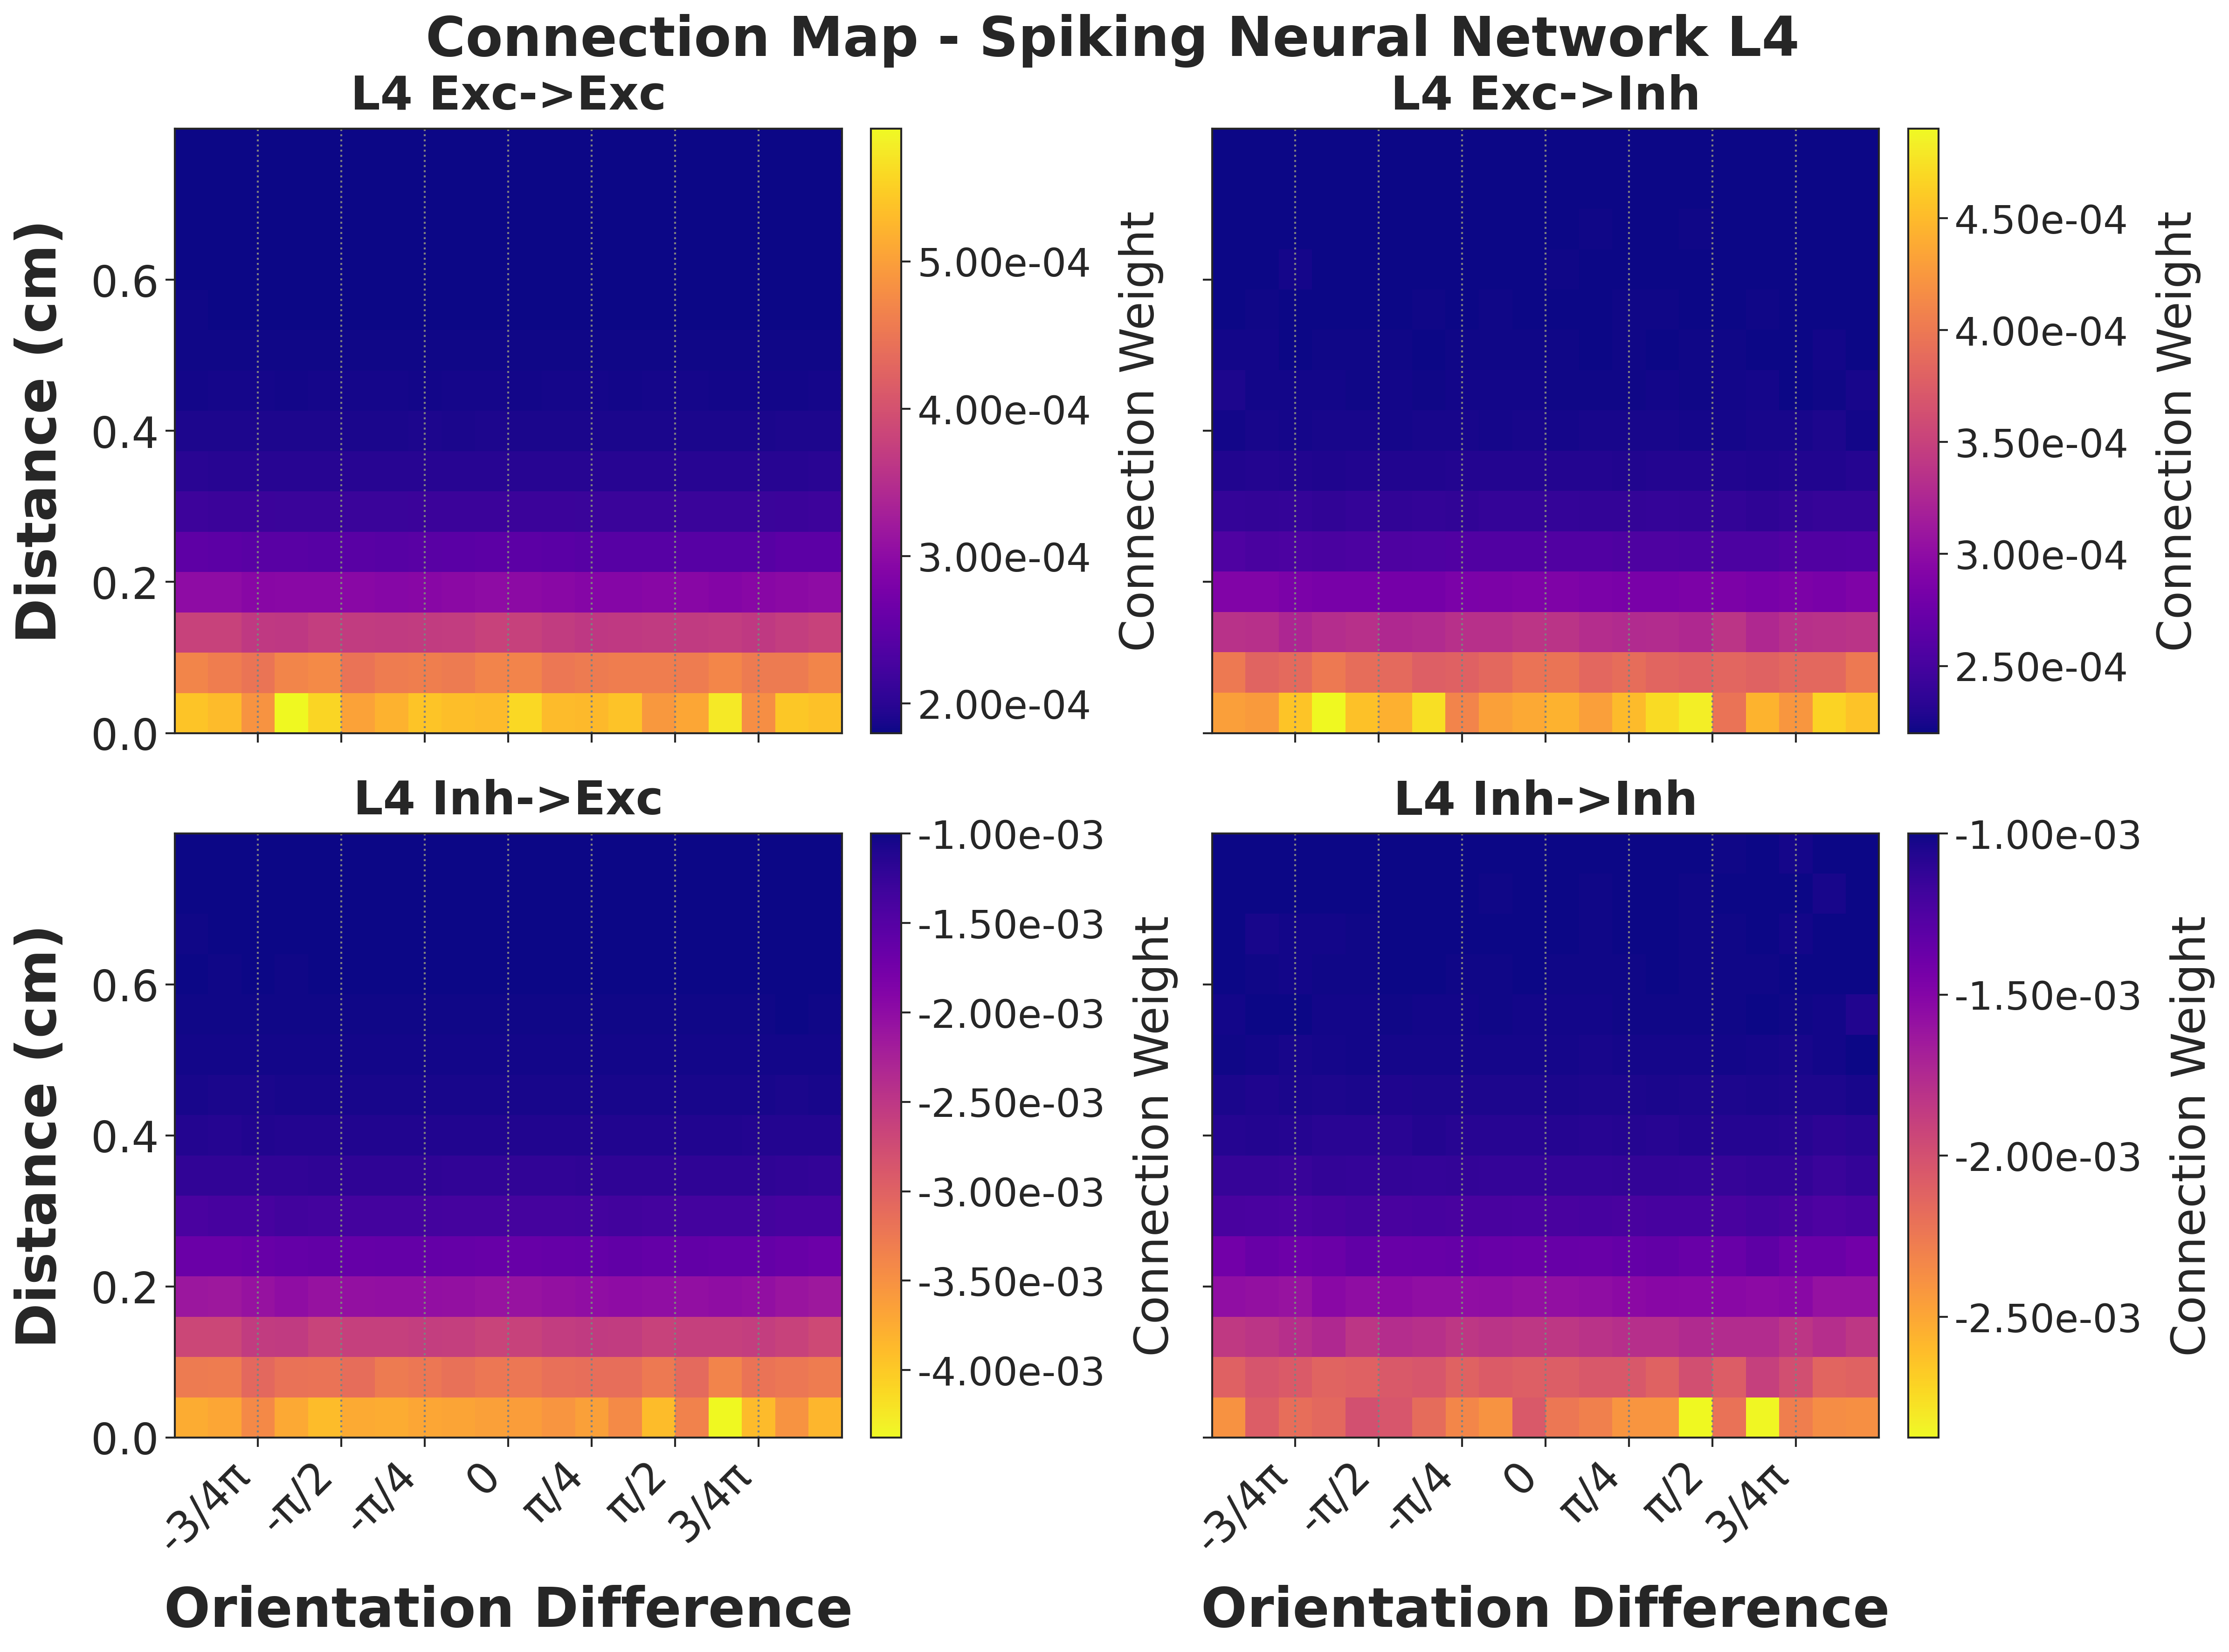

In [32]:
x_feat_snn, dist_snn, pred_snn = plot(l4_snn, save_fig="poster/connections_snn_l4.pdf", bin_size=(20, 15), max_dist=0.8, title="Connection Map - Spiking Neural Network L4")

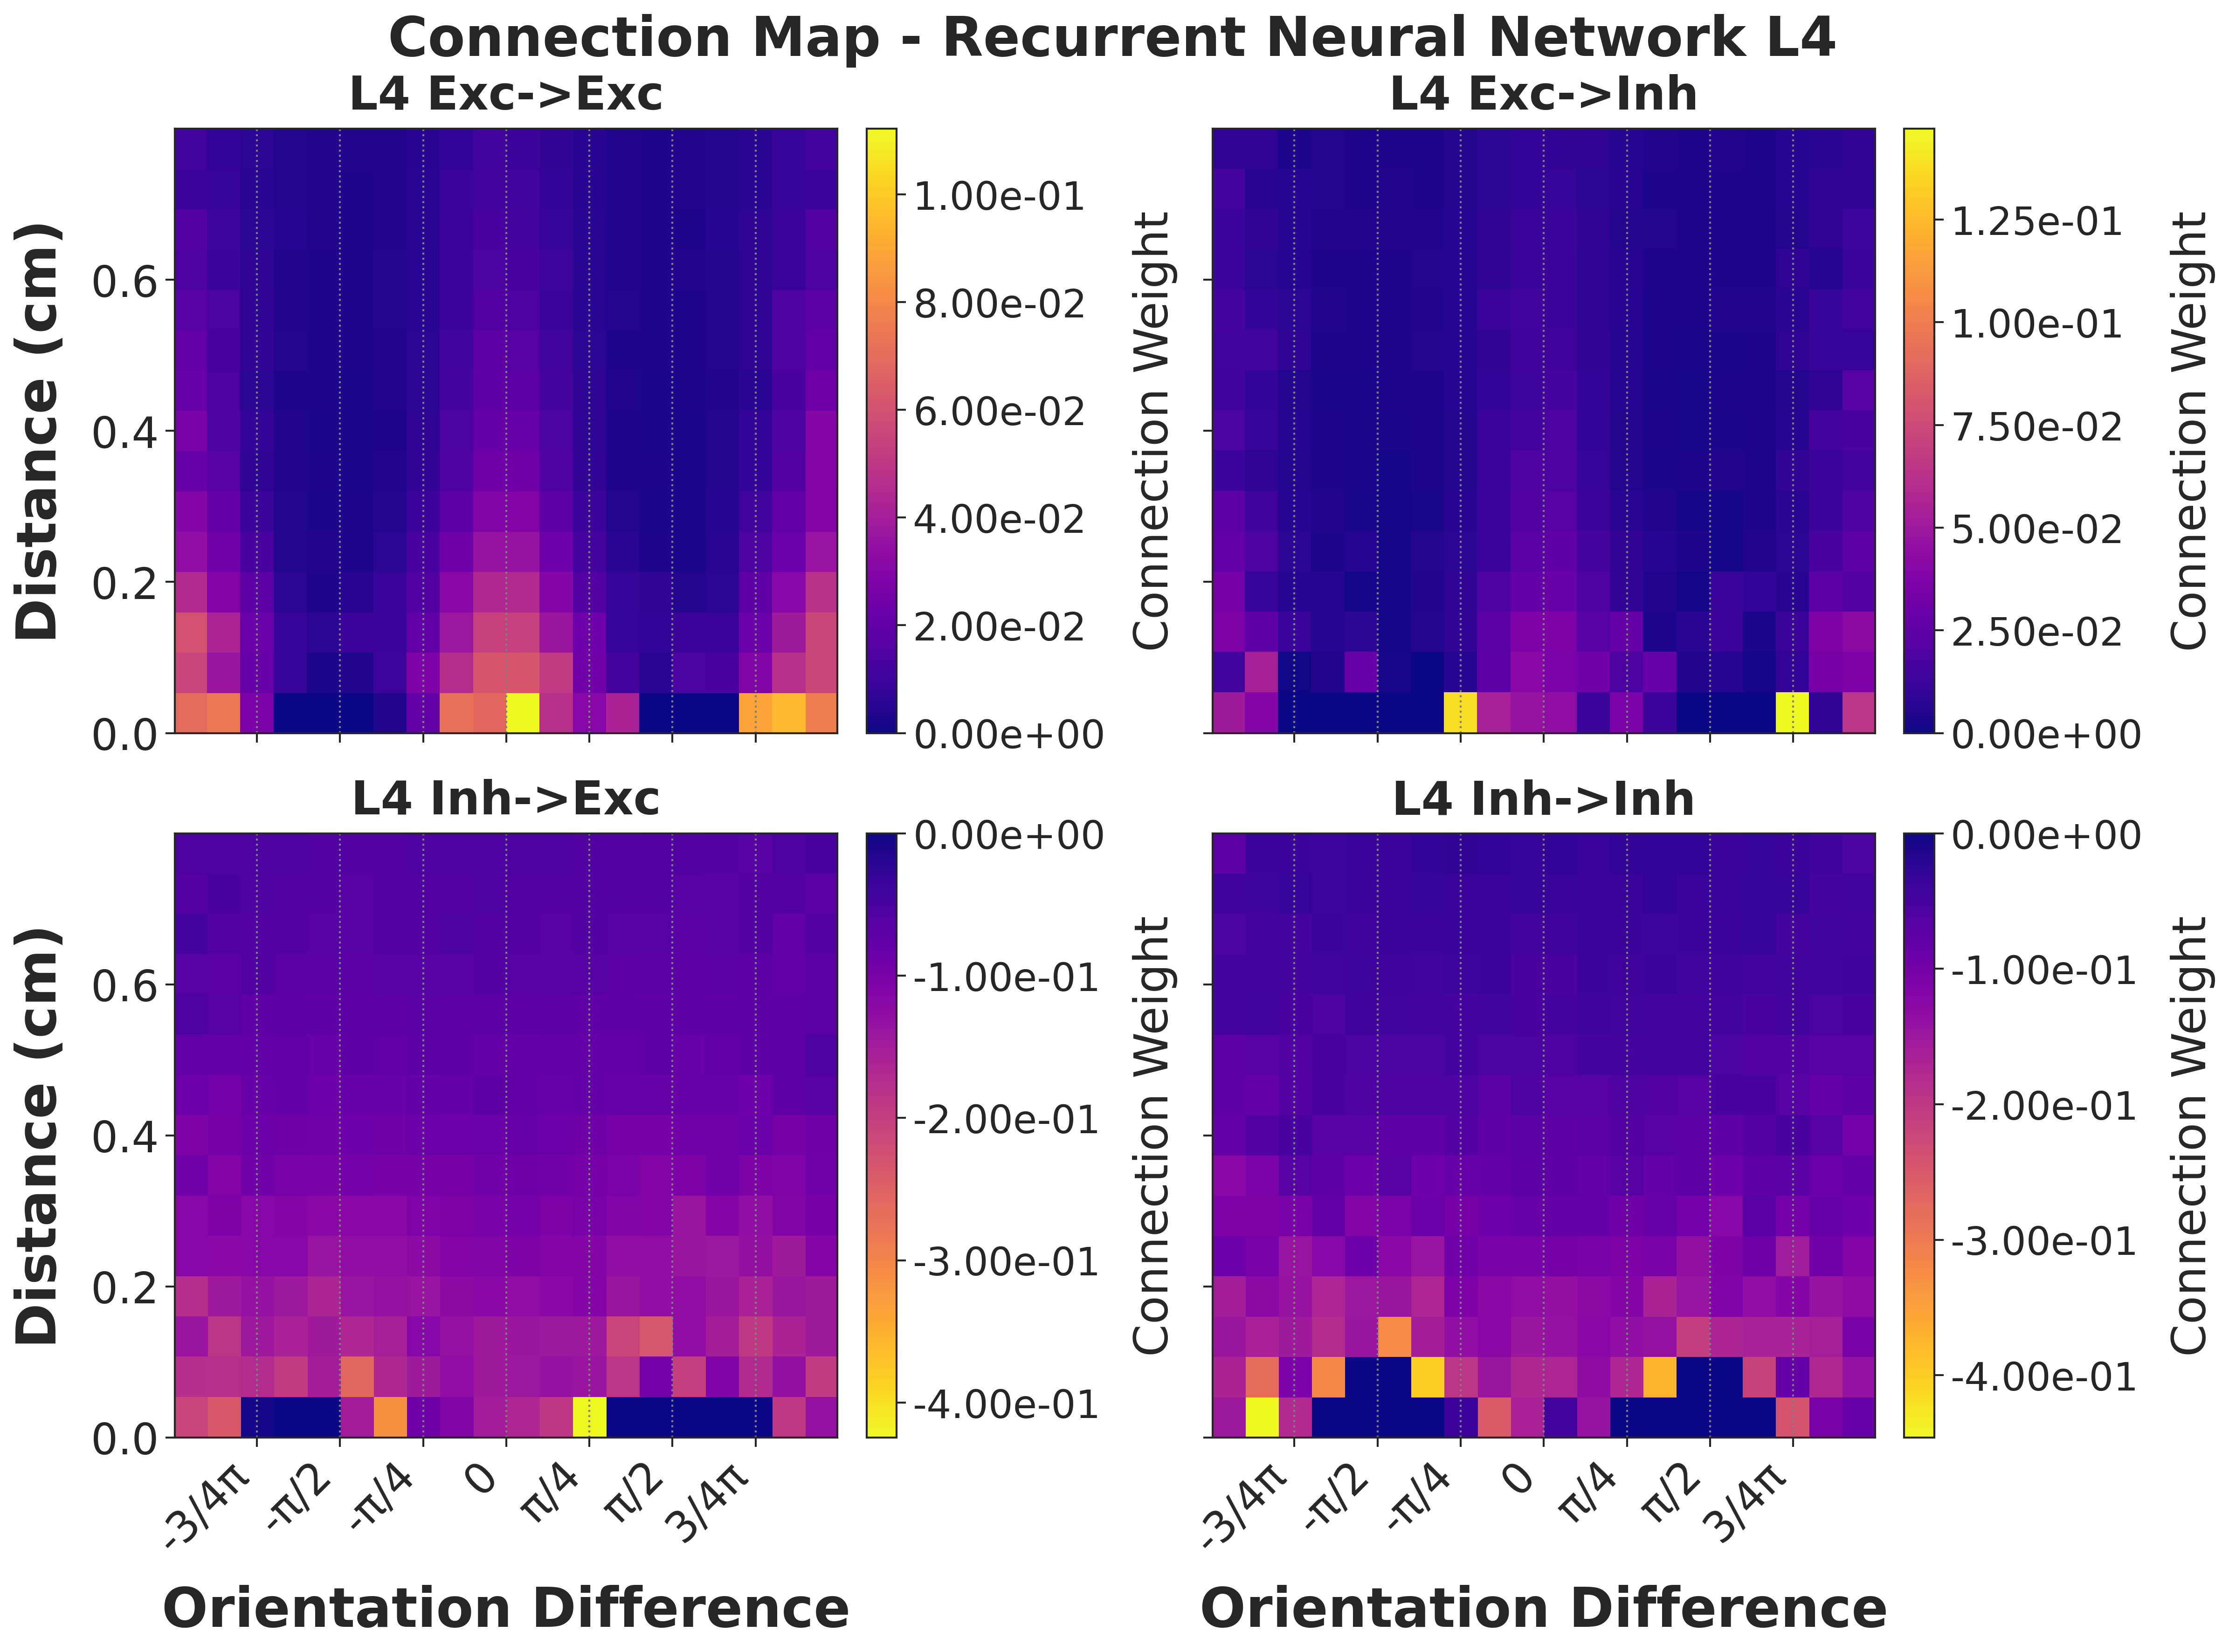

(array([ 0.        , -0.1765362 , -0.38364655, ..., -0.21915662,
        -1.3382303 ,  0.        ], dtype=float32),
 array([0.        , 0.23984711, 0.18938036, ..., 0.18685716, 0.76615703,
        0.        ], dtype=float32),
 array([-5.4772168e-05, -7.5563199e-05, -1.4251880e-01, ...,
        -3.4159869e-01, -2.4260348e-02, -5.6708268e-06], dtype=float32))

In [33]:
plot(l4_rnn, save_fig="poster/connections_rnn_l4.pdf", max_dist=0.8, title="Connection Map - Recurrent Neural Network L4")

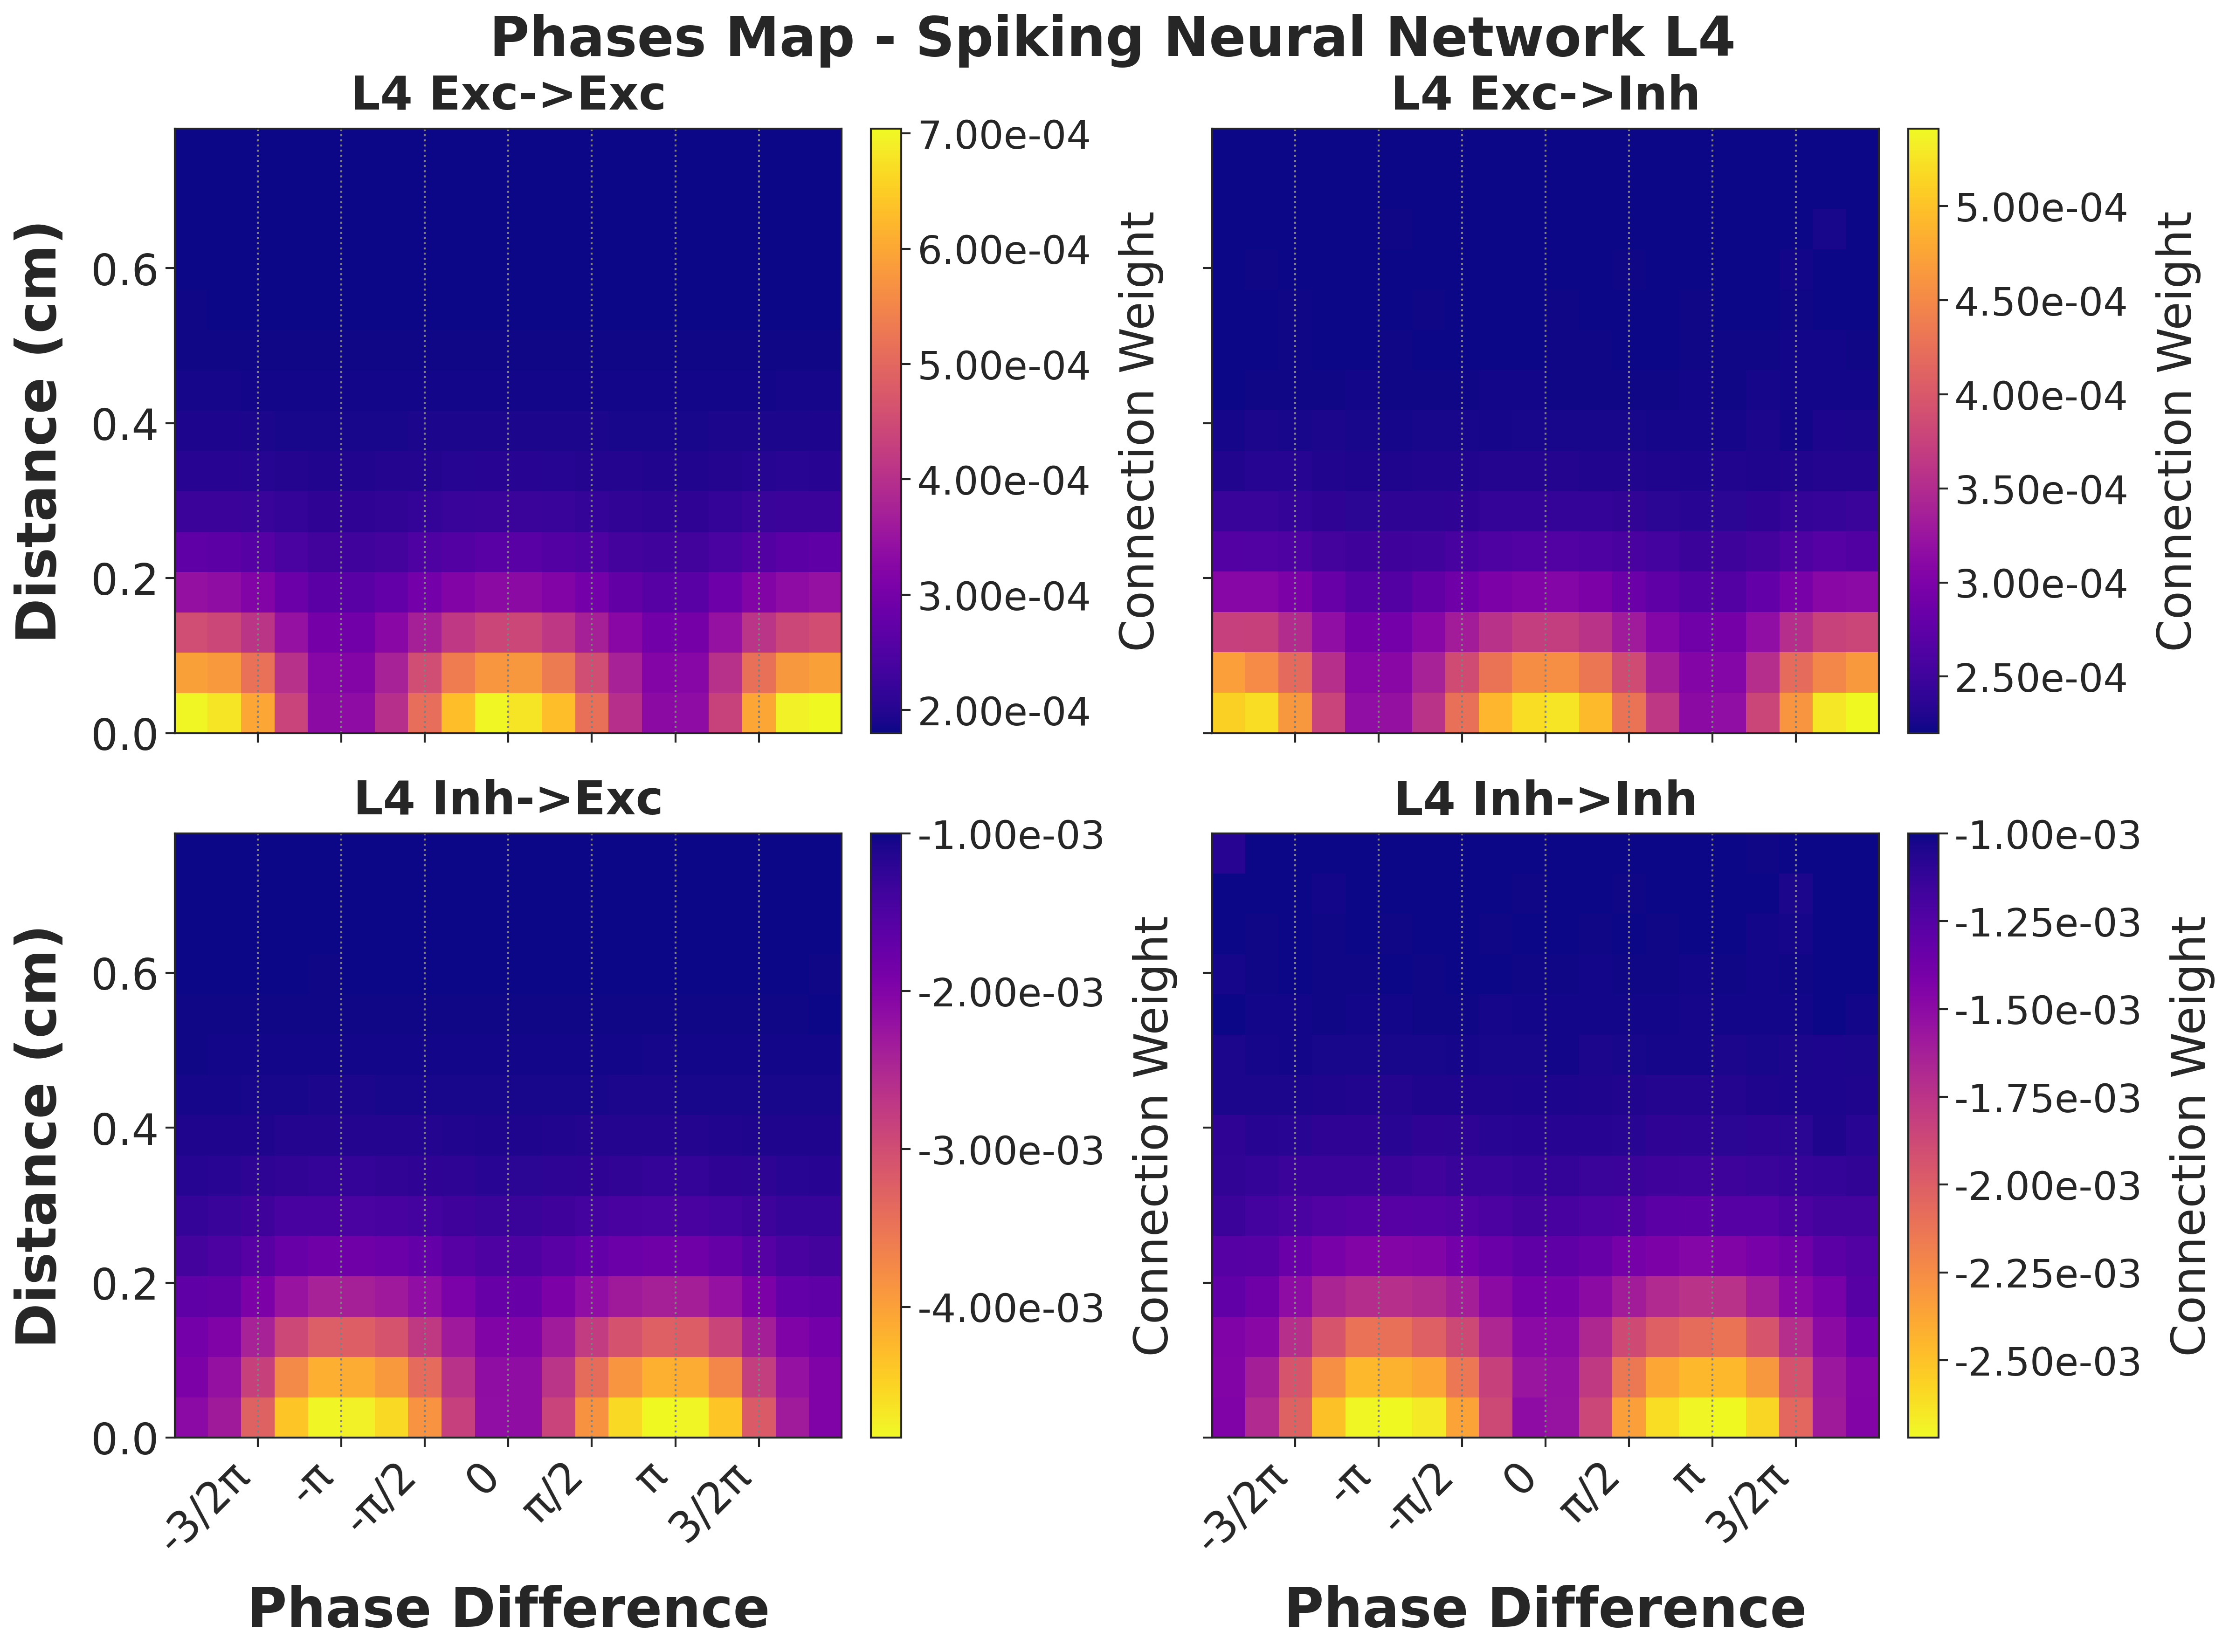

(0        -0.852478
 1        -1.790552
 2        -2.838527
 3        -1.709840
 4        -4.615614
             ...   
 778133    3.189965
 778134    3.076942
 778135    4.520590
 778136   -0.401333
 778138    4.813889
 Name: dphase, Length: 775056, dtype: float64,
 0         0.315513
 1         0.254815
 2         0.221774
 3         0.367816
 4         0.252962
             ...   
 778133    0.151307
 778134    0.469204
 778135    0.275279
 778136    0.355677
 778138    0.292105
 Name: dist, Length: 775056, dtype: float64,
 0        -0.001
 1        -0.001
 2        -0.002
 3        -0.001
 4        -0.001
           ...  
 778133   -0.002
 778134   -0.001
 778135   -0.002
 778136   -0.001
 778138   -0.001
 Name: w, Length: 775056, dtype: float64)

In [7]:
plot(l4_snn,  'phase', save_fig="poster/phases_snn_l4.pdf", max_dist=0.78, title="Phases Map - Spiking Neural Network L4")

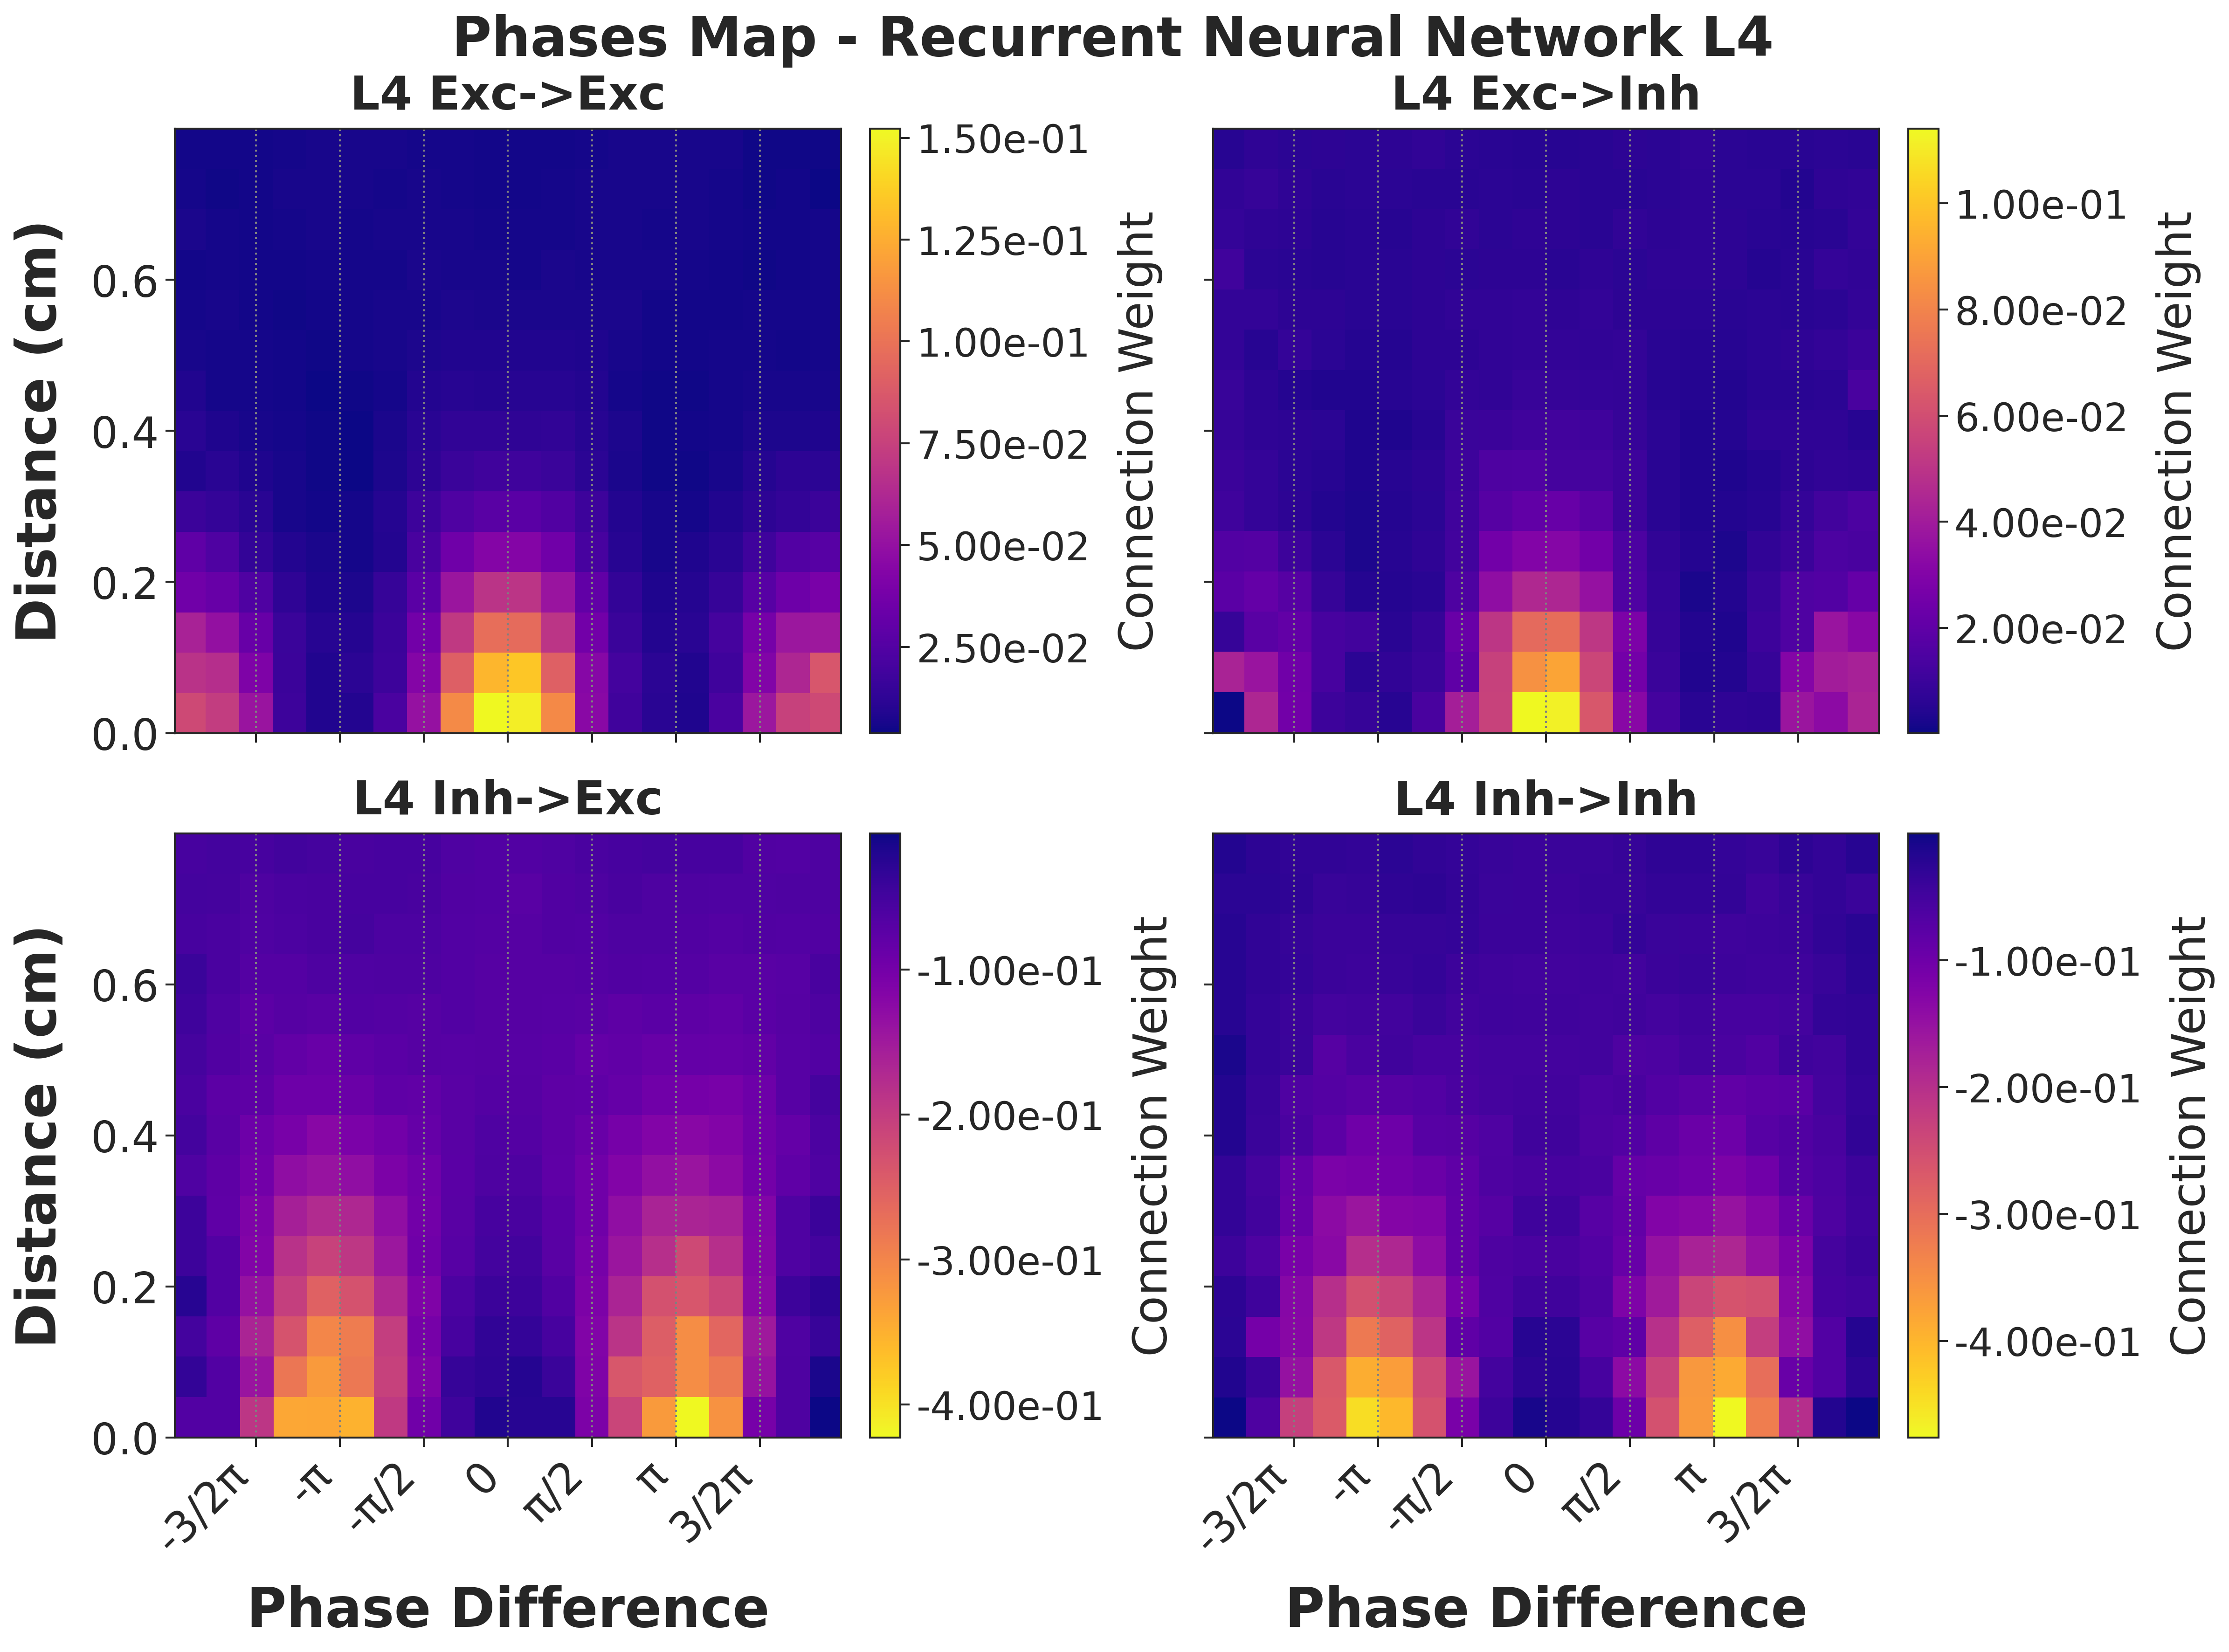

(array([ 0.       ,  0.1777978, -1.3331792, ..., -1.891551 , -3.6549425,
         0.       ], dtype=float32),
 array([0.        , 0.23984711, 0.18938036, ..., 0.18685716, 0.76615703,
        0.        ], dtype=float32),
 array([-5.4772168e-05, -7.5563199e-05, -1.4251880e-01, ...,
        -3.4159869e-01, -2.4260348e-02, -5.6708268e-06], dtype=float32))

In [35]:
plot(l4_rnn, 'phase', save_fig="poster/phases_rnn_l4.pdf", max_dist=0.8, title="Phases Map - Recurrent Neural Network L4")

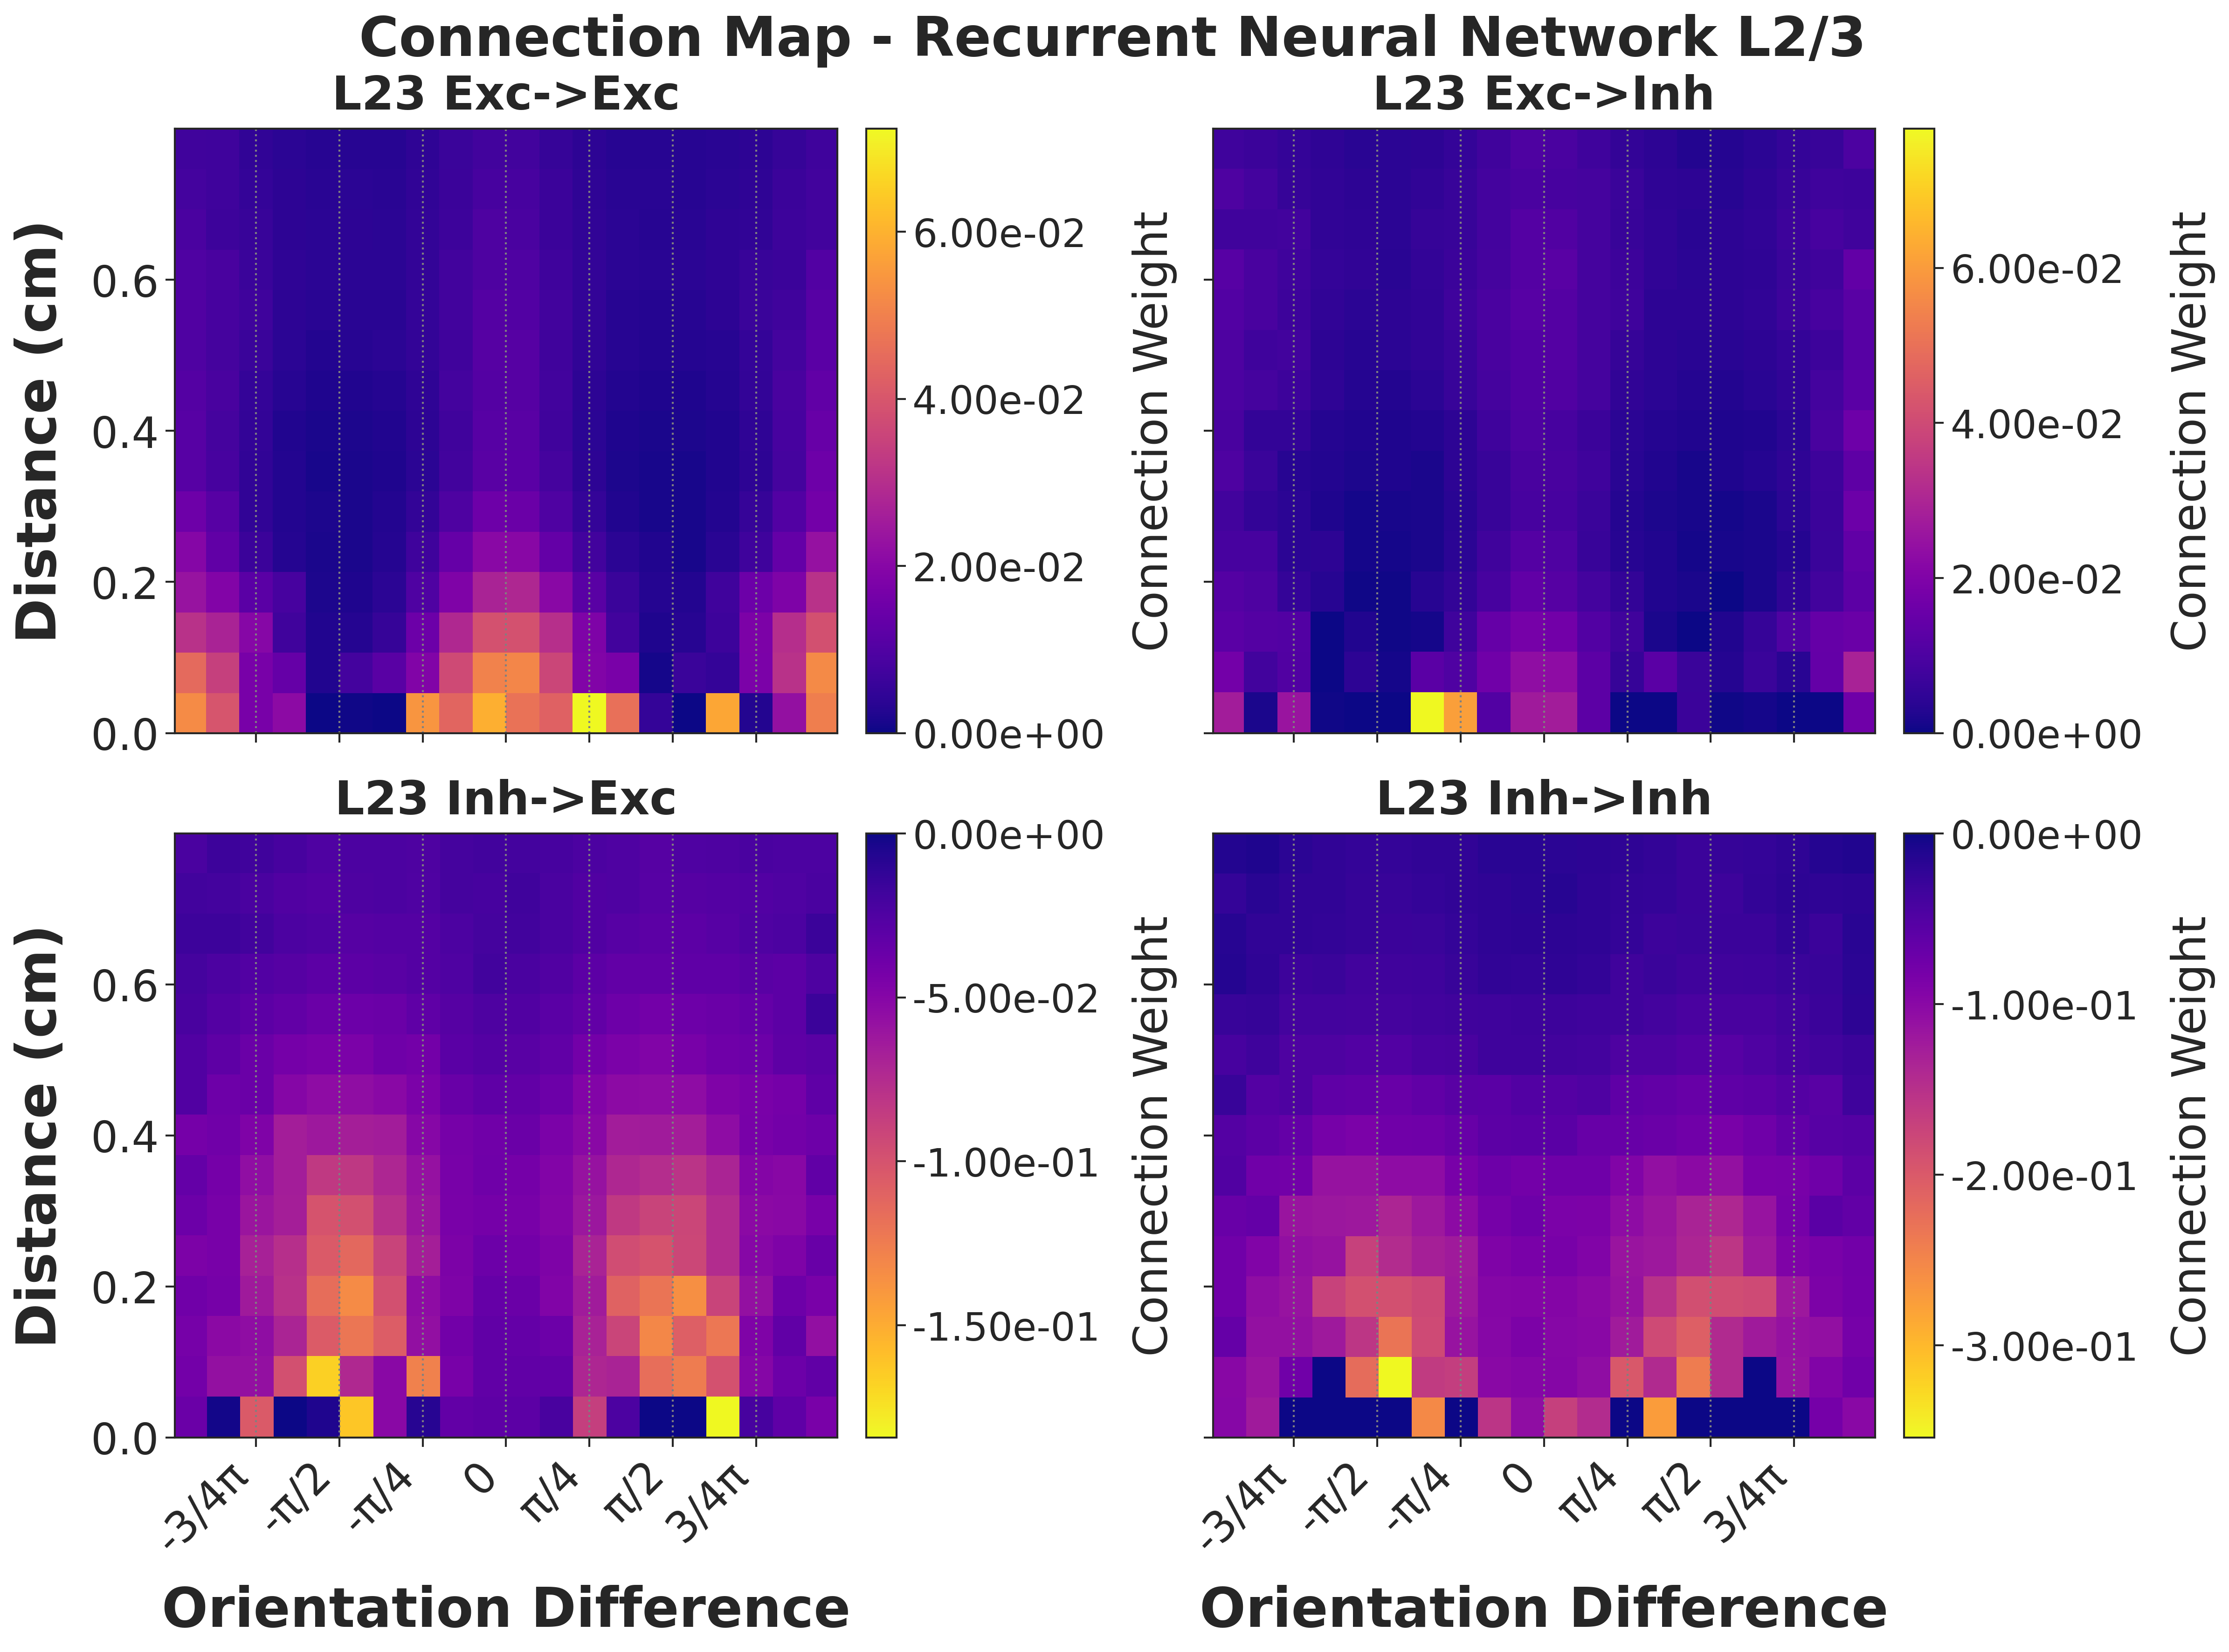

(array([ 0.        ,  0.85153604, -0.42662764, ..., -0.49383855,
        -1.2845191 ,  0.        ], dtype=float32),
 array([0.        , 0.33836257, 0.2741881 , ..., 0.5008294 , 0.5167335 ,
        0.        ], dtype=float32),
 array([-1.55732855e-01, -2.02212542e-01, -2.43674852e-02, ...,
        -1.15011035e-05, -7.92493299e-02, -4.06241208e-01], dtype=float32))

In [36]:
plot(l23_rnn, save_fig="poster/connections_rnn_l23.pdf", max_dist=0.8, title="Connection Map - Recurrent Neural Network L2/3")

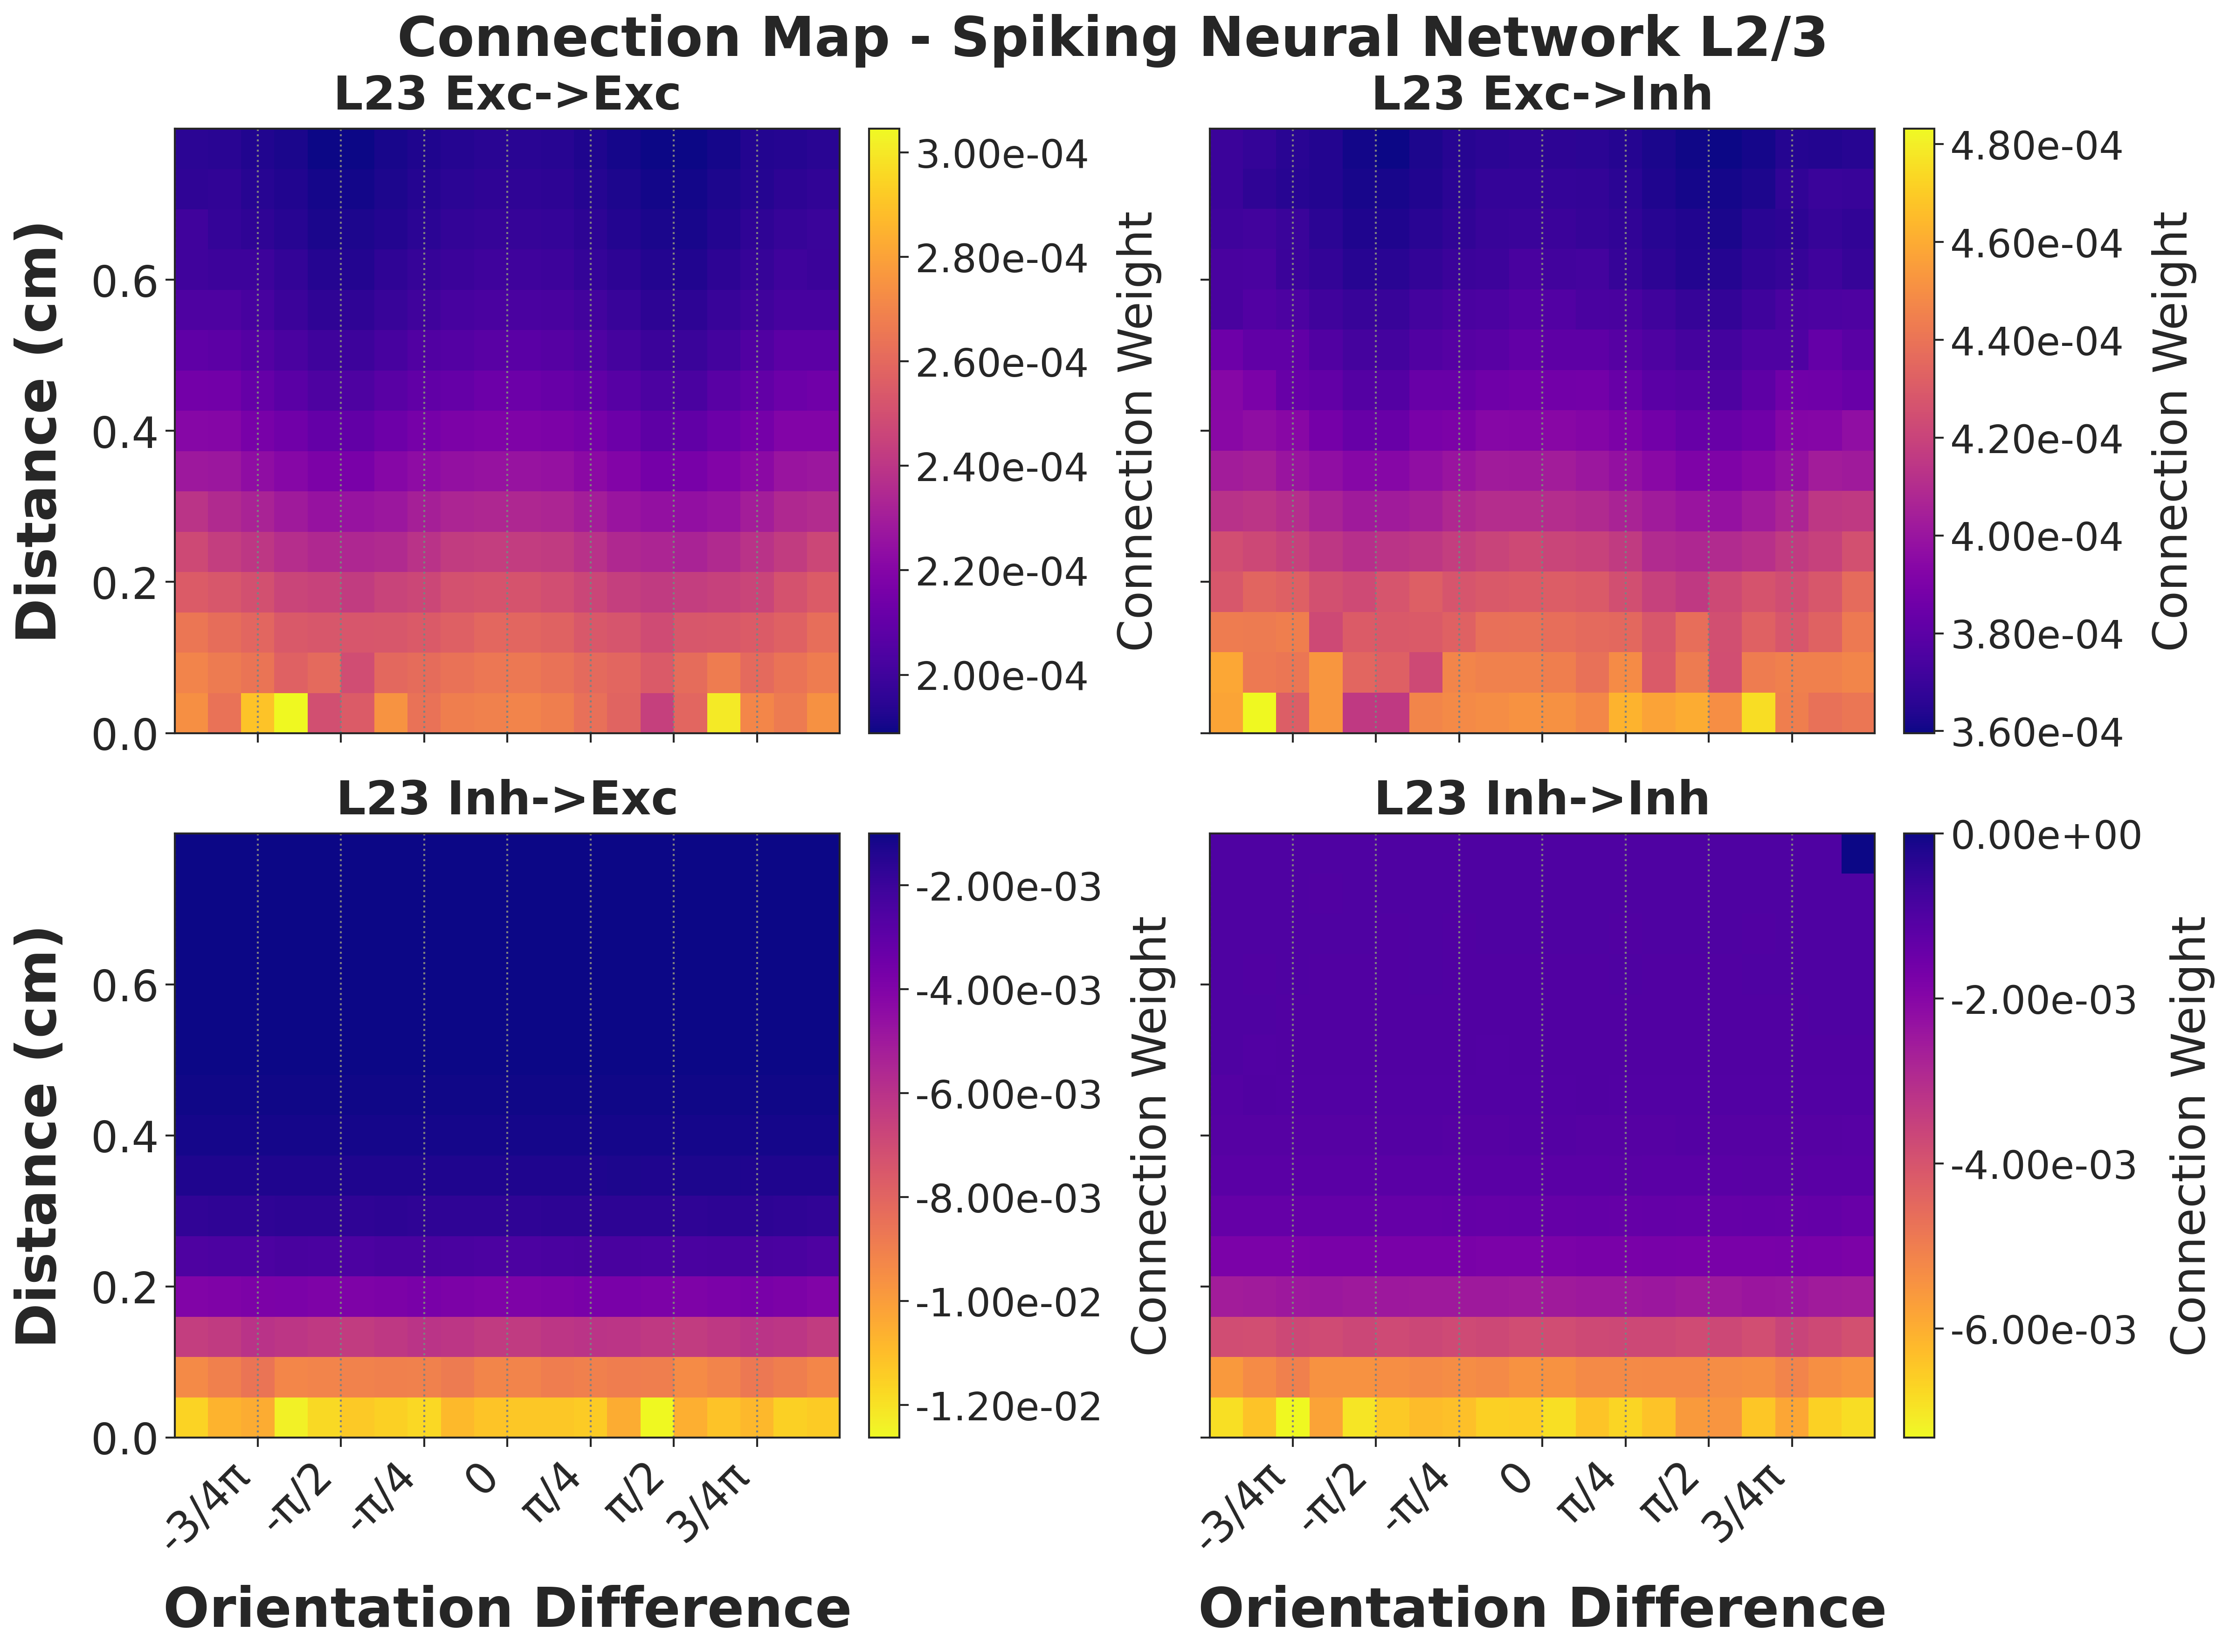

(0          0.653160
 1          0.259880
 2          0.064595
 3         -0.480707
 4          2.184767
              ...   
 1036295   -0.090361
 1036296    0.153619
 1036297    0.247154
 1036298   -0.168203
 1036299   -0.020660
 Name: dori, Length: 1035758, dtype: float64,
 0          0.332255
 1          0.242336
 2          0.215119
 3          0.240881
 4          0.326141
              ...   
 1036295    0.178561
 1036296    0.198768
 1036297    0.222211
 1036298    0.380771
 1036299    0.073917
 Name: dist, Length: 1035758, dtype: float64,
 0         -0.001
 1         -0.001
 2         -0.002
 3         -0.002
 4         -0.001
            ...  
 1036295   -0.004
 1036296   -0.004
 1036297   -0.001
 1036298   -0.001
 1036299   -0.004
 Name: w, Length: 1035758, dtype: float64)

In [37]:
plot(l23_snn, save_fig="poster/connections_snn_l23.pdf", max_dist=0.8, title="Connection Map - Spiking Neural Network L2/3")

In [16]:
# 